In [1]:
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd
import numpy as np
import os

In [2]:
from sklearn.datasets import fetch_openml
df = fetch_openml(data_id=41214, as_frame=True).frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


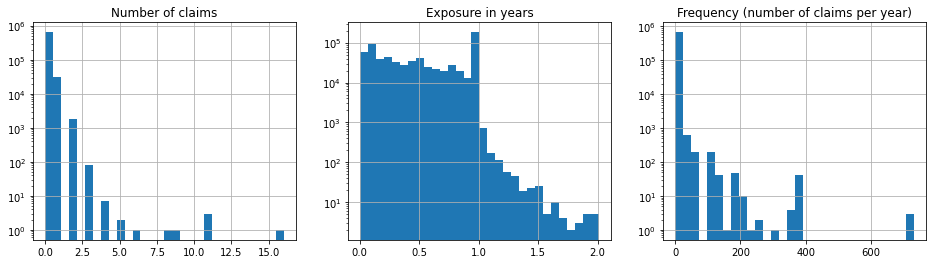

In [3]:
%matplotlib inline
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree

In [6]:
# converting type(str) columns to categorical
df['Area'] = df['Area'].astype('category').cat.codes
df['VehGas'] = df['VehGas'].astype('category').cat.codes
df['VehBrand'] = df['VehBrand'].astype('category').cat.codes
df['Region'] = df['Region'].astype('category').cat.codes

In [7]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

In [69]:
frequency_train = df_train.Frequency
exposure_train = df_train.Exposure
df_1 = df_train.drop(['ClaimNb','Frequency','Exposure'], 1)

In [72]:
rgf_dt = tree.DecisionTreeRegressor(criterion="mse", max_depth = 3,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = 0, splitter="best").fit(df_1,frequency_train,exposure_train)

In [98]:
pred = rgf_dt.predict(df_1)

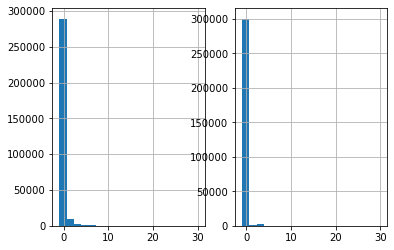

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=2)
frequency_train.hist(bins=np.linspace(-1, 30, n_bins), ax = ax[0])
pd.Series(pred).hist(bins=np.linspace(-1, 30, n_bins), ax = ax[1])
axes[row_idx, 0].set_title("Data")
axes[row_idx, 0].set_yscale("log")
axes[row_idx, 0].set_xlabel("y (observed Frequency)")
axes[row_idx, 0].set_ylim([10, 500])
axes[row_idx, 0].set_xlim([1, 10])
plt.ticklabel_format(axis="y")

In [ ]:
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

In [73]:
text_representation = tree.export_text(rgf_dt, feature_names = list(df_1.columns))
print(text_representation)

|--- IDpol <= 24931.50
|   |--- IDpol <= 14303.00
|   |   |--- IDpol <= 10472.50
|   |   |   |--- value: [3.34]
|   |   |--- IDpol >  10472.50
|   |   |   |--- value: [24.76]
|   |--- IDpol >  14303.00
|   |   |--- VehAge <= 0.50
|   |   |   |--- value: [3.07]
|   |   |--- VehAge >  0.50
|   |   |   |--- value: [1.37]
|--- IDpol >  24931.50
|   |--- BonusMalus <= 57.50
|   |   |--- Density <= 400.50
|   |   |   |--- value: [0.05]
|   |   |--- Density >  400.50
|   |   |   |--- value: [0.06]
|   |--- BonusMalus >  57.50
|   |   |--- BonusMalus <= 95.50
|   |   |   |--- value: [0.11]
|   |   |--- BonusMalus >  95.50
|   |   |   |--- value: [0.26]



In [113]:
rgf_dt_1 = tree.DecisionTreeRegressor(criterion="poisson", max_depth = 3,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = 0, splitter="best").fit(np.array(df_1),frequency_train,exposure_train)

In [114]:
pred_1 = rgf_dt_1.predict(df_1)

In [115]:
pred_1

array([0.08580983, 0.08580983, 0.08580983, ..., 0.08580983, 0.08580983,
       0.08580983])

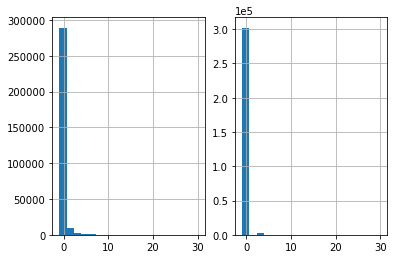

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2)
frequency_train.hist(bins=np.linspace(-1, 30, n_bins), ax = ax[0])
pd.Series(pred_1).hist(bins=np.linspace(-1, 30, n_bins), ax = ax[1])
axes[row_idx, 0].set_title("Data")
axes[row_idx, 0].set_yscale("log")
axes[row_idx, 0].set_xlabel("y (observed Frequency)")
axes[row_idx, 0].set_ylim([1e1, 5e5])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [75]:
text_representation = tree.export_text(rgf_dt_1, feature_names = list(df_1.columns))
print(text_representation)

|--- IDpol <= 14303.00
|   |--- IDpol <= 11266.00
|   |   |--- IDpol <= 11198.50
|   |   |   |--- value: [3.47]
|   |   |--- IDpol >  11198.50
|   |   |   |--- value: [36.36]
|   |--- IDpol >  11266.00
|   |   |--- DrivAge <= 35.50
|   |   |   |--- value: [91.62]
|   |   |--- DrivAge >  35.50
|   |   |   |--- value: [41.45]
|--- IDpol >  14303.00
|   |--- IDpol <= 16734.00
|   |   |--- value: [1.74]
|   |--- IDpol >  16734.00
|   |   |--- BonusMalus <= 184.00
|   |   |   |--- value: [0.09]
|   |   |--- BonusMalus >  184.00
|   |   |   |--- value: [1.54]



In [76]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [77]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

#Let’s compute the performance of this constant prediction baseline with 3 different regression metrics:

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.571
MAE: 0.189
mean Poisson deviance: 0.631


In [78]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [79]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.567
MAE: 0.178
mean Poisson deviance: 0.607


In [80]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.567
MAE: 0.186
mean Poisson deviance: 0.600


In [81]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.566
MAE: 0.184
mean Poisson deviance: 0.584


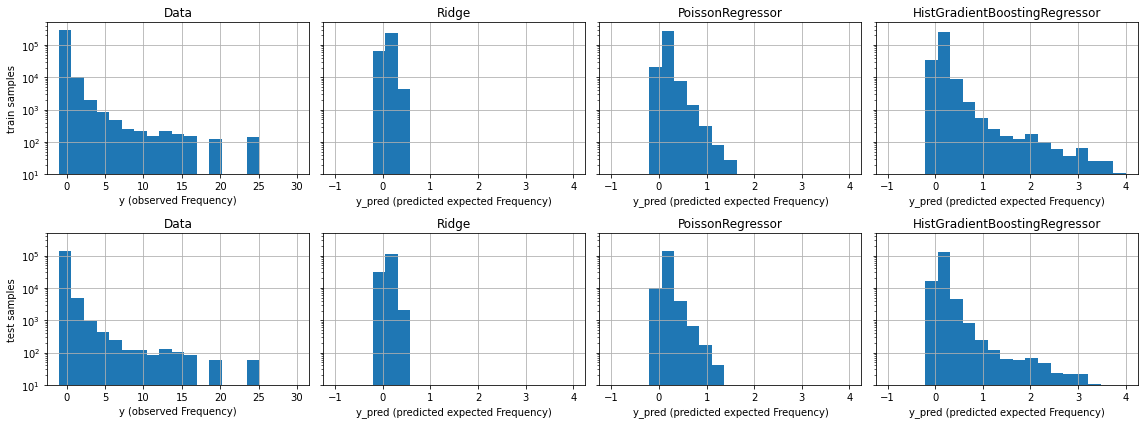

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()